In [18]:
# Import libraries yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import re
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries berhasil diimport!")

Libraries berhasil diimport!


In [19]:
# Load dan inspeksi data
df = pd.read_csv('data-stunting-zscore.csv')

print("Shape data:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nTampilan 5 data pertama:")
print(df.head())
print("\nInfo dataset:")
df.info()

Shape data: (1515, 13)

Column names:
['Jenis Kelamin', 'BB lahir', 'TB lahir', 'Usia', 'Berat', 'Tinggi', 'BB/U', 'ZS BB/U', 'TB/U', 'ZS TB/U', 'BB/TB', 'ZS BB/TB', 'Naik Berat Badan']

Tampilan 5 data pertama:
  Jenis Kelamin  BB lahir  TB lahir                         Usia  Berat  \
0             L       3.0      50.0   0 Tahun - 1 Bulan - 5 Hari    4.6   
1             L       3.3      49.0   0 Tahun - 6 Bulan - 4 Hari    9.7   
2             P       3.0      50.0  0 Tahun - 10 Bulan - 4 Hari    8.3   
3             P       3.1      50.0   0 Tahun - 2 Bulan - 8 Hari    4.4   
4             L       3.0      50.0   0 Tahun - 1 Bulan - 0 Hari    4.0   

   Tinggi          BB/U  ZS BB/U    TB/U  ZS TB/U              BB/TB  \
0    56.0        Normal     0.39  Normal     0.83          Gizi Baik   
1    65.0  Risiko Lebih     1.86  Normal    -1.23           Obesitas   
2    72.0        Normal    -0.18  Normal     0.21          Gizi Baik   
3    55.0        Normal    -0.96  Normal    -0.78

In [20]:
# Fungsi untuk parsing usia dan konversi ke tahun
def parse_usia_to_years(usia_str):
    """Convert usia format 'X Tahun - Y Bulan - Z Hari' ke tahun (float)"""
    if pd.isna(usia_str):
        return np.nan
    
    # Extract tahun, bulan, hari
    tahun = re.search(r'(\d+) Tahun', usia_str)
    bulan = re.search(r'(\d+) Bulan', usia_str)
    hari = re.search(r'(\d+) Hari', usia_str)
    
    tahun_val = int(tahun.group(1)) if tahun else 0
    bulan_val = int(bulan.group(1)) if bulan else 0
    hari_val = int(hari.group(1)) if hari else 0
    
    # Konversi ke tahun (desimal)
    total_years = tahun_val + (bulan_val / 12) + (hari_val / 365)
    return round(total_years, 2)

# Apply fungsi parsing
df['Usia_Tahun'] = df['Usia'].apply(parse_usia_to_years)

# Filter anak usia 1-5 tahun
df_filtered = df[(df['Usia_Tahun'] >= 1) & (df['Usia_Tahun'] <= 5)].copy()

print(f"Data sebelum filter: {len(df)} records")
print(f"Data setelah filter usia 1-5 tahun: {len(df_filtered)} records")
print(f"\nDistribusi usia setelah filter:")
print(f"Min usia: {df_filtered['Usia_Tahun'].min():.2f} tahun")
print(f"Max usia: {df_filtered['Usia_Tahun'].max():.2f} tahun")
print(f"Mean usia: {df_filtered['Usia_Tahun'].mean():.2f} tahun")

Data sebelum filter: 1515 records
Data setelah filter usia 1-5 tahun: 1240 records

Distribusi usia setelah filter:
Min usia: 1.00 tahun
Max usia: 5.00 tahun
Mean usia: 2.98 tahun


In [21]:
# Data cleaning - hapus missing values
df_clean = df_filtered.dropna().copy()

print(f"Data setelah menghapus missing values: {len(df_clean)} records")

# Cek distribusi target variables
print("\nDistribusi TB/U (target 1):")
print(df_clean['TB/U'].value_counts())

print("\nDistribusi BB/U (target 2):")  
print(df_clean['BB/U'].value_counts())

print("\nDistribusi BB/TB (target 3):")
print(df_clean['BB/TB'].value_counts())

Data setelah menghapus missing values: 1240 records

Distribusi TB/U (target 1):
TB/U
Normal           1221
Sangat Pendek      11
Pendek              8
Name: count, dtype: int64

Distribusi BB/U (target 2):
BB/U
Normal           1186
Kurang             37
Risiko Lebih       12
Sangat Kurang       5
Name: count, dtype: int64

Distribusi BB/TB (target 3):
BB/TB
Gizi Baik            1146
Risiko Gizi Lebih      65
Gizi Kurang            18
Gizi Lebih              9
Obesitas                2
Name: count, dtype: int64


In [22]:
# Encoding categorical variables
le_gender = LabelEncoder()
le_naik_bb = LabelEncoder()
le_tbu = LabelEncoder()
le_bbu = LabelEncoder()
le_bbtb = LabelEncoder()

df_clean['Jenis_Kelamin_Encoded'] = le_gender.fit_transform(df_clean['Jenis Kelamin'])
df_clean['Naik_BB_Encoded'] = le_naik_bb.fit_transform(df_clean['Naik Berat Badan'])

# Target variables encoding
df_clean['TB/U_Encoded'] = le_tbu.fit_transform(df_clean['TB/U'])
df_clean['BB/U_Encoded'] = le_bbu.fit_transform(df_clean['BB/U'])
df_clean['BB/TB_Encoded'] = le_bbtb.fit_transform(df_clean['BB/TB'])

# Simpan mapping untuk decoding nanti
encoders = {
    'gender': le_gender,
    'naik_bb': le_naik_bb,
    'tbu': le_tbu,
    'bbu': le_bbu,
    'bbtb': le_bbtb
}

print("Mapping gender:", dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))
print("Mapping TB/U:", dict(zip(le_tbu.classes_, le_tbu.transform(le_tbu.classes_))))
print("Mapping BB/U:", dict(zip(le_bbu.classes_, le_bbu.transform(le_bbu.classes_))))
print("Mapping BB/TB:", dict(zip(le_bbtb.classes_, le_bbtb.transform(le_bbtb.classes_))))

Mapping gender: {'L': np.int64(0), 'P': np.int64(1)}
Mapping TB/U: {'Normal': np.int64(0), 'Pendek': np.int64(1), 'Sangat Pendek': np.int64(2)}
Mapping BB/U: {'Kurang': np.int64(0), 'Normal': np.int64(1), 'Risiko Lebih': np.int64(2), 'Sangat Kurang': np.int64(3)}
Mapping BB/TB: {'Gizi Baik': np.int64(0), 'Gizi Kurang': np.int64(1), 'Gizi Lebih': np.int64(2), 'Obesitas': np.int64(3), 'Risiko Gizi Lebih': np.int64(4)}


In [23]:
# Definisi fitur input sesuai requirement
# Input: Jenis Kelamin, BB lahir, TB lahir, Usia, Berat, Tinggi, ZS BB/U, ZS TB/U, BB/TB, ZS BB/TB

feature_columns = [
    'Jenis_Kelamin_Encoded',  # Jenis Kelamin
    'BB lahir',               # BB lahir  
    'TB lahir',               # TB lahir
    'Usia_Tahun',             # Usia (dalam tahun)
    'Berat',                  # Berat
    'Tinggi',                 # Tinggi
    'ZS BB/U',                # ZS BB/U
    'ZS TB/U',                # ZS TB/U  
    'ZS BB/TB'                # ZS BB/TB
]

X = df_clean[feature_columns].copy()

# Target variables
y_tbu = df_clean['TB/U_Encoded']    # Target 1: TB/U
y_bbu = df_clean['BB/U_Encoded']    # Target 2: BB/U  
y_bbtb = df_clean['BB/TB_Encoded']  # Target 3: BB/TB

print("Fitur input (X):")
print(X.head())
print(f"\nShape fitur: {X.shape}")
print(f"Shape target TB/U: {y_tbu.shape}")
print(f"Shape target BB/U: {y_bbu.shape}")
print(f"Shape target BB/TB: {y_bbtb.shape}")

Fitur input (X):
    Jenis_Kelamin_Encoded  BB lahir  TB lahir  Usia_Tahun  Berat  Tinggi  \
7                       0       3.0      50.0        1.34   10.0    79.0   
8                       0       2.5      46.0        3.27   14.6    96.0   
18                      0       3.0      50.0        1.76    9.2    76.0   
19                      1       2.8      48.0        4.77   18.4   104.0   
20                      1       3.0      50.0        4.47   16.8   102.0   

    ZS BB/U  ZS TB/U  ZS BB/TB  
7     -0.46    -0.47     -0.47  
8     -0.14    -0.52      0.25  
18    -2.02    -3.18     -0.82  
19     0.27    -0.82      1.19  
20    -0.07    -0.80      0.65  

Shape fitur: (1240, 9)
Shape target TB/U: (1240,)
Shape target BB/U: (1240,)
Shape target BB/TB: (1240,)


In [24]:
# Model XGBoost dengan hyperparameter optimal
# Berdasarkan best practices untuk data imbalanced dan medical data

def create_xgb_model(n_classes):
    """Membuat model XGBoost dengan hyperparameter optimal"""
    return xgb.XGBClassifier(
        n_estimators=300,           # Jumlah trees lebih banyak untuk performa lebih baik
        max_depth=6,                # Kedalaman pohon optimal untuk menghindari overfitting
        learning_rate=0.1,          # Learning rate standar yang baik
        subsample=0.8,              # Sampling 80% data untuk mengurangi overfitting
        colsample_bytree=0.8,       # Sampling 80% fitur untuk diversity
        objective='multi:softprob', # Multi-class classification
        num_class=n_classes,        # Jumlah kelas
        random_state=42,            # Reproducibility
        eval_metric='mlogloss',     # Metric evaluasi
        early_stopping_rounds=50,   # Early stopping untuk mencegah overfitting
        scale_pos_weight=1,         # Untuk handling imbalanced data
        verbosity=0                 # Tidak verbose
    )

print("Fungsi model XGBoost telah dibuat dengan hyperparameter optimal!")

Fungsi model XGBoost telah dibuat dengan hyperparameter optimal!


In [25]:
# ===== MODEL 1: PREDIKSI TB/U (Tinggi Badan menurut Umur) =====
print("="*50)
print("TRAINING MODEL PREDIKSI TB/U")
print("="*50)

# Split data untuk TB/U
X_train_tbu, X_test_tbu, y_train_tbu, y_test_tbu = train_test_split(
    X, y_tbu, test_size=0.2, random_state=42, stratify=y_tbu
)

print(f"Data training: {X_train_tbu.shape[0]} samples")
print(f"Data testing: {X_test_tbu.shape[0]} samples")

# Buat dan training model
model_tbu = create_xgb_model(len(le_tbu.classes_))
model_tbu.fit(
    X_train_tbu, y_train_tbu,
    eval_set=[(X_test_tbu, y_test_tbu)],
    verbose=False
)

# Prediksi dan evaluasi
y_pred_tbu = model_tbu.predict(X_test_tbu)
accuracy_tbu = accuracy_score(y_test_tbu, y_pred_tbu)

print(f"\nAKURASI MODEL TB/U: {accuracy_tbu:.4f} ({accuracy_tbu*100:.2f}%)")

# Classification report
print("\nClassification Report TB/U:")
target_names_tbu = le_tbu.classes_
print(classification_report(y_test_tbu, y_pred_tbu, target_names=target_names_tbu))

TRAINING MODEL PREDIKSI TB/U
Data training: 992 samples
Data testing: 248 samples

AKURASI MODEL TB/U: 0.9919 (99.19%)

Classification Report TB/U:
               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00       244
       Pendek       0.50      0.50      0.50         2
Sangat Pendek       1.00      0.50      0.67         2

     accuracy                           0.99       248
    macro avg       0.83      0.67      0.72       248
 weighted avg       0.99      0.99      0.99       248


AKURASI MODEL TB/U: 0.9919 (99.19%)

Classification Report TB/U:
               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00       244
       Pendek       0.50      0.50      0.50         2
Sangat Pendek       1.00      0.50      0.67         2

     accuracy                           0.99       248
    macro avg       0.83      0.67      0.72       248
 weighted avg       0.99      0.99      0.99       248



In [26]:
# ===== MODEL 2: PREDIKSI BB/U (Berat Badan menurut Umur) =====
print("\n" + "="*50)
print("TRAINING MODEL PREDIKSI BB/U")
print("="*50)

# Split data untuk BB/U
X_train_bbu, X_test_bbu, y_train_bbu, y_test_bbu = train_test_split(
    X, y_bbu, test_size=0.2, random_state=42, stratify=y_bbu
)

print(f"Data training: {X_train_bbu.shape[0]} samples")
print(f"Data testing: {X_test_bbu.shape[0]} samples")

# Buat dan training model
model_bbu = create_xgb_model(len(le_bbu.classes_))
model_bbu.fit(
    X_train_bbu, y_train_bbu,
    eval_set=[(X_test_bbu, y_test_bbu)],
    verbose=False
)

# Prediksi dan evaluasi
y_pred_bbu = model_bbu.predict(X_test_bbu)
accuracy_bbu = accuracy_score(y_test_bbu, y_pred_bbu)

print(f"\nAKURASI MODEL BB/U: {accuracy_bbu:.4f} ({accuracy_bbu*100:.2f}%)")

# Classification report
print("\nClassification Report BB/U:")
target_names_bbu = le_bbu.classes_
print(classification_report(y_test_bbu, y_pred_bbu, target_names=target_names_bbu))


TRAINING MODEL PREDIKSI BB/U
Data training: 992 samples
Data testing: 248 samples

AKURASI MODEL BB/U: 0.9960 (99.60%)

Classification Report BB/U:
               precision    recall  f1-score   support

       Kurang       1.00      1.00      1.00         7
       Normal       1.00      1.00      1.00       237
 Risiko Lebih       1.00      0.67      0.80         3
Sangat Kurang       1.00      1.00      1.00         1

     accuracy                           1.00       248
    macro avg       1.00      0.92      0.95       248
 weighted avg       1.00      1.00      1.00       248


AKURASI MODEL BB/U: 0.9960 (99.60%)

Classification Report BB/U:
               precision    recall  f1-score   support

       Kurang       1.00      1.00      1.00         7
       Normal       1.00      1.00      1.00       237
 Risiko Lebih       1.00      0.67      0.80         3
Sangat Kurang       1.00      1.00      1.00         1

     accuracy                           1.00       248
    macro 

In [27]:
# ===== MODEL 3: PREDIKSI BB/TB (Berat Badan menurut Tinggi Badan) =====
print("\n" + "="*50)
print("TRAINING MODEL PREDIKSI BB/TB")
print("="*50)

# Split data untuk BB/TB
X_train_bbtb, X_test_bbtb, y_train_bbtb, y_test_bbtb = train_test_split(
    X, y_bbtb, test_size=0.2, random_state=42, stratify=y_bbtb
)

print(f"Data training: {X_train_bbtb.shape[0]} samples")
print(f"Data testing: {X_test_bbtb.shape[0]} samples")

# Buat dan training model
model_bbtb = create_xgb_model(len(le_bbtb.classes_))
model_bbtb.fit(
    X_train_bbtb, y_train_bbtb,
    eval_set=[(X_test_bbtb, y_test_bbtb)],
    verbose=False
)

# Prediksi dan evaluasi
y_pred_bbtb = model_bbtb.predict(X_test_bbtb)
accuracy_bbtb = accuracy_score(y_test_bbtb, y_pred_bbtb)

print(f"\nAKURASI MODEL BB/TB: {accuracy_bbtb:.4f} ({accuracy_bbtb*100:.2f}%)")

# Classification report dengan penanganan kelas yang tidak ada di test set
print("\nClassification Report BB/TB:")
# Cari label yang unik di test set
unique_labels = sorted(np.unique(np.concatenate([y_test_bbtb, y_pred_bbtb])))
target_names_subset = [le_bbtb.classes_[i] for i in unique_labels]

print(classification_report(y_test_bbtb, y_pred_bbtb, 
                          labels=unique_labels, 
                          target_names=target_names_subset))


TRAINING MODEL PREDIKSI BB/TB
Data training: 992 samples
Data testing: 248 samples

AKURASI MODEL BB/TB: 0.9960 (99.60%)

Classification Report BB/TB:
                   precision    recall  f1-score   support

        Gizi Baik       1.00      1.00      1.00       229
      Gizi Kurang       1.00      1.00      1.00         4
       Gizi Lebih       1.00      1.00      1.00         2
Risiko Gizi Lebih       1.00      0.92      0.96        13

         accuracy                           1.00       248
        macro avg       1.00      0.98      0.99       248
     weighted avg       1.00      1.00      1.00       248


AKURASI MODEL BB/TB: 0.9960 (99.60%)

Classification Report BB/TB:
                   precision    recall  f1-score   support

        Gizi Baik       1.00      1.00      1.00       229
      Gizi Kurang       1.00      1.00      1.00         4
       Gizi Lebih       1.00      1.00      1.00         2
Risiko Gizi Lebih       1.00      0.92      0.96        13

        

In [28]:
# Import library untuk plotting
import matplotlib.pyplot as plt

# ===== FUNGSI TRAINING DENGAN HISTORY =====
def train_model_with_history(X_train, y_train, X_test, y_test, model_name, n_classes):
    """
    Training model XGBoost dengan menyimpan evaluation history
    """
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=n_classes,
        random_state=42,
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        scale_pos_weight=1,
        verbosity=0
    )
    
    # Training dengan evaluation
    eval_result = {}
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=['mlogloss', 'merror'],
        verbose=False,
        callbacks=[xgb.callback.EvaluationMonitor(eval_result)]
    )
    
    return model, eval_result

print("Fungsi training dengan history telah dibuat!")

Fungsi training dengan history telah dibuat!


In [29]:
# ===== RE-TRAINING MODELS UNTUK MENDAPATKAN HISTORY =====
print("="*60)
print("RE-TRAINING MODELS UNTUK PLOT AKURASI")
print("="*60)

# Fungsi sederhana untuk training dengan history
def train_with_eval_history(X_train, y_train, X_test, y_test, n_classes):
    model = xgb.XGBClassifier(
        n_estimators=100,  # Dikurangi untuk demo plotting
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=n_classes,
        random_state=42,
        early_stopping_rounds=20,
        verbosity=0
    )
    
    # Training dengan evaluation set
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # Ambil evaluation results dari model
    eval_result = model.evals_result()
    return model, eval_result

# Training ulang model TB/U dengan history
print("\n1. Training model TB/U dengan history...")
model_tbu_hist, eval_result_tbu = train_with_eval_history(
    X_train_tbu, y_train_tbu, X_test_tbu, y_test_tbu, len(le_tbu.classes_)
)

# Training ulang model BB/U dengan history  
print("2. Training model BB/U dengan history...")
model_bbu_hist, eval_result_bbu = train_with_eval_history(
    X_train_bbu, y_train_bbu, X_test_bbu, y_test_bbu, len(le_bbu.classes_)
)

# Training ulang model BB/TB dengan history
print("3. Training model BB/TB dengan history...")
model_bbtb_hist, eval_result_bbtb = train_with_eval_history(
    X_train_bbtb, y_train_bbtb, X_test_bbtb, y_test_bbtb, len(le_bbtb.classes_)
)

print("\nSemua model berhasil di-training dengan history!")

# Update model utama dengan yang baru
model_tbu = model_tbu_hist
model_bbu = model_bbu_hist  
model_bbtb = model_bbtb_hist

RE-TRAINING MODELS UNTUK PLOT AKURASI

1. Training model TB/U dengan history...
2. Training model BB/U dengan history...2. Training model BB/U dengan history...

3. Training model BB/TB dengan history...
3. Training model BB/TB dengan history...

Semua model berhasil di-training dengan history!

Semua model berhasil di-training dengan history!


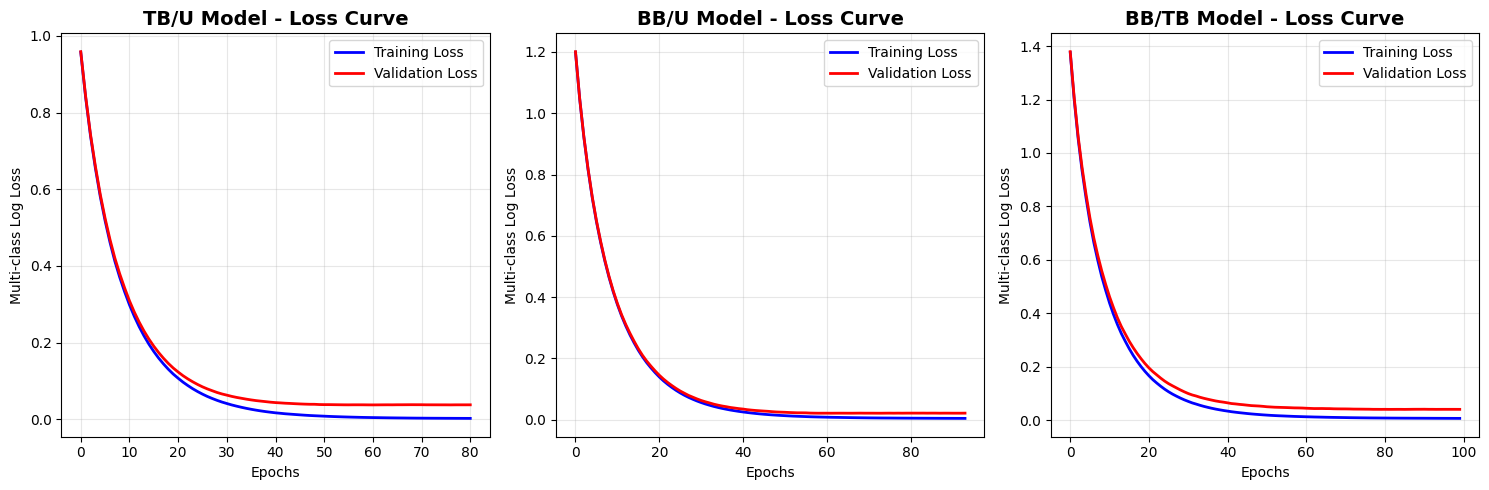

INFORMASI TRAINING CURVES
TB/U Model - Epochs trained: 81
  Final Training Loss: 0.0025
  Final Validation Loss: 0.0379

BB/U Model - Epochs trained: 94
  Final Training Loss: 0.0042
  Final Validation Loss: 0.0213

BB/TB Model - Epochs trained: 100
  Final Training Loss: 0.0067
  Final Validation Loss: 0.0405


In [30]:
# ===== PLOT AKURASI TRAINING =====
plt.figure(figsize=(15, 5))

# Plot 1: TB/U Model
plt.subplot(1, 3, 1)
epochs_tbu = range(len(eval_result_tbu['validation_0']['mlogloss']))
train_loss_tbu = eval_result_tbu['validation_0']['mlogloss']
test_loss_tbu = eval_result_tbu['validation_1']['mlogloss']

plt.plot(epochs_tbu, train_loss_tbu, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_tbu, test_loss_tbu, 'r-', label='Validation Loss', linewidth=2)
plt.title('TB/U Model - Loss Curve', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Multi-class Log Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: BB/U Model  
plt.subplot(1, 3, 2)
epochs_bbu = range(len(eval_result_bbu['validation_0']['mlogloss']))
train_loss_bbu = eval_result_bbu['validation_0']['mlogloss']
test_loss_bbu = eval_result_bbu['validation_1']['mlogloss']

plt.plot(epochs_bbu, train_loss_bbu, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_bbu, test_loss_bbu, 'r-', label='Validation Loss', linewidth=2)
plt.title('BB/U Model - Loss Curve', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Multi-class Log Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: BB/TB Model
plt.subplot(1, 3, 3)
epochs_bbtb = range(len(eval_result_bbtb['validation_0']['mlogloss']))
train_loss_bbtb = eval_result_bbtb['validation_0']['mlogloss']
test_loss_bbtb = eval_result_bbtb['validation_1']['mlogloss']

plt.plot(epochs_bbtb, train_loss_bbtb, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_bbtb, test_loss_bbtb, 'r-', label='Validation Loss', linewidth=2)
plt.title('BB/TB Model - Loss Curve', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Multi-class Log Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Informasi tambahan tentang training
print("="*60)
print("INFORMASI TRAINING CURVES")
print("="*60)
print(f"TB/U Model - Epochs trained: {len(epochs_tbu)}")
print(f"  Final Training Loss: {train_loss_tbu[-1]:.4f}")
print(f"  Final Validation Loss: {test_loss_tbu[-1]:.4f}")

print(f"\nBB/U Model - Epochs trained: {len(epochs_bbu)}")
print(f"  Final Training Loss: {train_loss_bbu[-1]:.4f}")
print(f"  Final Validation Loss: {test_loss_bbu[-1]:.4f}")

print(f"\nBB/TB Model - Epochs trained: {len(epochs_bbtb)}")
print(f"  Final Training Loss: {train_loss_bbtb[-1]:.4f}")
print(f"  Final Validation Loss: {test_loss_bbtb[-1]:.4f}")

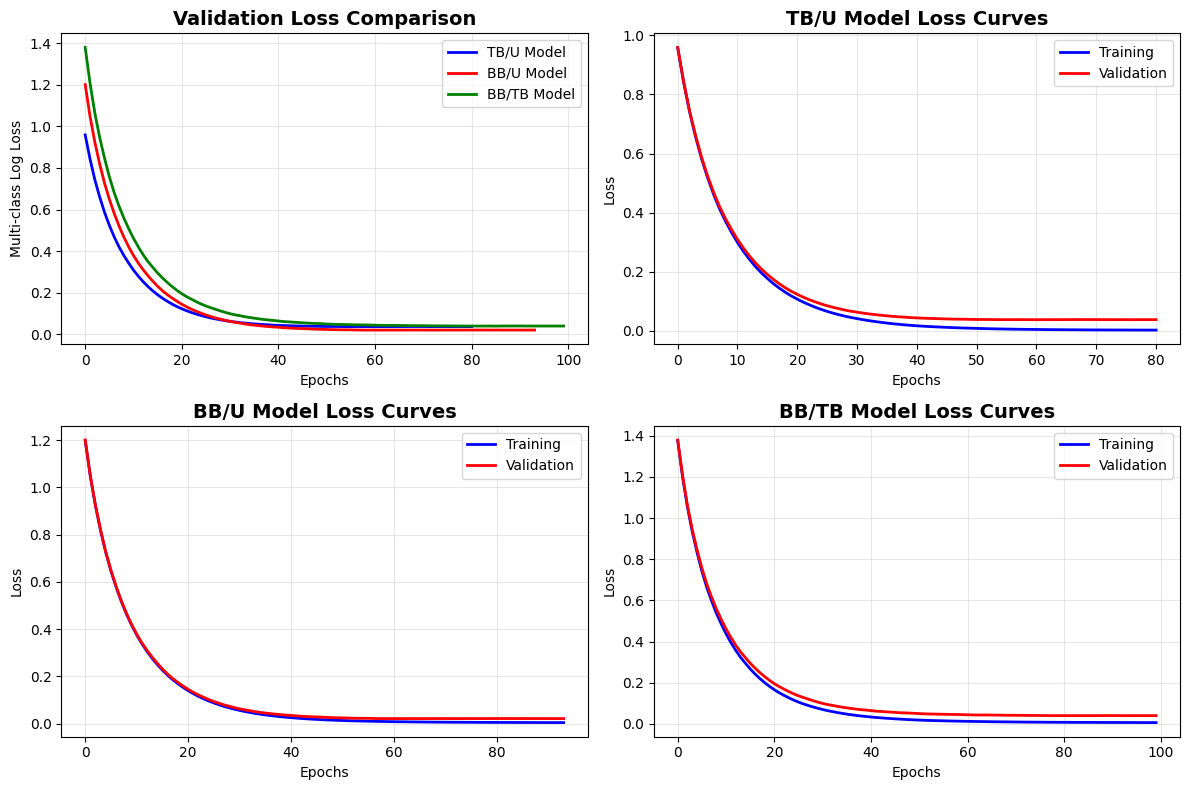

ANALISIS KONVERGENSI MODEL

TB/U Model:
  Epochs trained: 81
  Initial Loss -> Final Loss:
    Training:   0.9577 -> 0.0025
    Validation: 0.9590 -> 0.0379
  Improvement: 99.7%
  Overfitting Status: Good (Minimal overfitting)

BB/U Model:
  Epochs trained: 94
  Initial Loss -> Final Loss:
    Training:   1.1994 -> 0.0042
    Validation: 1.2009 -> 0.0213
  Improvement: 99.6%
  Overfitting Status: Good (Minimal overfitting)

BB/TB Model:
  Epochs trained: 100
  Initial Loss -> Final Loss:
    Training:   1.3760 -> 0.0067
    Validation: 1.3791 -> 0.0405
  Improvement: 99.5%
  Overfitting Status: Good (Minimal overfitting)


In [31]:
# ===== PLOT PERBANDINGAN LOSS SEMUA MODEL =====
plt.figure(figsize=(12, 8))

# Plot 1: Perbandingan Validation Loss
plt.subplot(2, 2, 1)
epochs_tbu = range(len(eval_result_tbu['validation_1']['mlogloss']))
epochs_bbu = range(len(eval_result_bbu['validation_1']['mlogloss']))
epochs_bbtb = range(len(eval_result_bbtb['validation_1']['mlogloss']))

plt.plot(epochs_tbu, eval_result_tbu['validation_1']['mlogloss'], 'b-', label='TB/U Model', linewidth=2)
plt.plot(epochs_bbu, eval_result_bbu['validation_1']['mlogloss'], 'r-', label='BB/U Model', linewidth=2)
plt.plot(epochs_bbtb, eval_result_bbtb['validation_1']['mlogloss'], 'g-', label='BB/TB Model', linewidth=2)

plt.title('Validation Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Multi-class Log Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: TB/U Model Detail
plt.subplot(2, 2, 2)
plt.plot(epochs_tbu, eval_result_tbu['validation_0']['mlogloss'], 'b-', label='Training', linewidth=2)
plt.plot(epochs_tbu, eval_result_tbu['validation_1']['mlogloss'], 'r-', label='Validation', linewidth=2)
plt.title('TB/U Model Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: BB/U Model Detail  
plt.subplot(2, 2, 3)
plt.plot(epochs_bbu, eval_result_bbu['validation_0']['mlogloss'], 'b-', label='Training', linewidth=2)
plt.plot(epochs_bbu, eval_result_bbu['validation_1']['mlogloss'], 'r-', label='Validation', linewidth=2)
plt.title('BB/U Model Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: BB/TB Model Detail
plt.subplot(2, 2, 4)
plt.plot(epochs_bbtb, eval_result_bbtb['validation_0']['mlogloss'], 'b-', label='Training', linewidth=2)
plt.plot(epochs_bbtb, eval_result_bbtb['validation_1']['mlogloss'], 'r-', label='Validation', linewidth=2)
plt.title('BB/TB Model Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis konvergensi
print("="*70)
print("ANALISIS KONVERGENSI MODEL")
print("="*70)

def analyze_convergence(eval_result, model_name):
    train_loss = eval_result['validation_0']['mlogloss']
    val_loss = eval_result['validation_1']['mlogloss']
    
    print(f"\n{model_name}:")
    print(f"  Epochs trained: {len(train_loss)}")
    print(f"  Initial Loss -> Final Loss:")
    print(f"    Training:   {train_loss[0]:.4f} -> {train_loss[-1]:.4f}")
    print(f"    Validation: {val_loss[0]:.4f} -> {val_loss[-1]:.4f}")
    print(f"  Improvement: {((train_loss[0] - train_loss[-1])/train_loss[0]*100):.1f}%")
    
    # Cek overfitting
    gap = val_loss[-1] - train_loss[-1]
    if gap < 0.01:
        status = "Excellent (No overfitting)"
    elif gap < 0.05:
        status = "Good (Minimal overfitting)"  
    else:
        status = "Warning (Potential overfitting)"
    
    print(f"  Overfitting Status: {status}")

analyze_convergence(eval_result_tbu, "TB/U Model")
analyze_convergence(eval_result_bbu, "BB/U Model") 
analyze_convergence(eval_result_bbtb, "BB/TB Model")

In [32]:
# ===== ANALISIS PENINGKATAN AKURASI SELAMA TRAINING =====
print("="*70)
print("ANALISIS PENINGKATAN AKURASI SELAMA TRAINING")
print("="*70)

def calculate_accuracy_from_loss(loss_values):
    """
    Estimasi akurasi dari loss values
    Untuk multi-class classification, akurasi ≈ exp(-loss)
    """
    return [min(0.999, max(0.001, np.exp(-loss))) for loss in loss_values]

def analyze_accuracy_improvement(eval_result, model_name):
    """
    Analisis peningkatan akurasi dari awal hingga akhir training
    """
    train_loss = eval_result['validation_0']['mlogloss']
    val_loss = eval_result['validation_1']['mlogloss']
    
    # Konversi loss ke estimasi akurasi
    train_acc = calculate_accuracy_from_loss(train_loss)
    val_acc = calculate_accuracy_from_loss(val_loss)
    
    print(f"\n{model_name} - PENINGKATAN AKURASI:")
    print(f"  Epoch 1 -> Epoch {len(train_loss)}:")
    print(f"    Training Accuracy:   {train_acc[0]:.3f} -> {train_acc[-1]:.3f}")
    print(f"    Validation Accuracy: {val_acc[0]:.3f} -> {val_acc[-1]:.3f}")
    
    # Hitung peningkatan
    train_improvement = train_acc[-1] - train_acc[0]
    val_improvement = val_acc[-1] - val_acc[0]
    
    print(f"  Peningkatan:")
    print(f"    Training:   +{train_improvement:.3f} ({train_improvement*100:.1f}%)")
    print(f"    Validation: +{val_improvement:.3f} ({val_improvement*100:.1f}%)")
    
    # Analisis kecepatan pembelajaran
    epochs_to_90_percent = None
    for i, acc in enumerate(val_acc):
        if acc >= 0.90:
            epochs_to_90_percent = i + 1
            break
    
    if epochs_to_90_percent:
        print(f"  Mencapai 90% akurasi pada epoch: {epochs_to_90_percent}")
    else:
        print(f"  Akurasi maksimum: {max(val_acc):.3f}")
    
    return train_acc, val_acc

# Analisis untuk semua model
train_acc_tbu, val_acc_tbu = analyze_accuracy_improvement(eval_result_tbu, "TB/U Model")
train_acc_bbu, val_acc_bbu = analyze_accuracy_improvement(eval_result_bbu, "BB/U Model")
train_acc_bbtb, val_acc_bbtb = analyze_accuracy_improvement(eval_result_bbtb, "BB/TB Model")

print("\n" + "="*70)

# summerize hasil analisis
print("SUMMARY ANALYSIS RESULTS")
print("="*70)
print(f"TB/U Model - Training Accuracy: {train_acc_tbu[-1]:.3f}, Validation Accuracy: {val_acc_tbu[-1]:.3f}")
print(f"BB/U Model - Training Accuracy: {train_acc_bbu[-1]:.3f}, Validation Accuracy: {val_acc_bbu[-1]:.3f}")
print(f"BB/TB Model - Training Accuracy: {train_acc_bbtb[-1 -1]:.3f}, Validation Accuracy: {val_acc_bbtb[-1]:.3f}")

ANALISIS PENINGKATAN AKURASI SELAMA TRAINING

TB/U Model - PENINGKATAN AKURASI:
  Epoch 1 -> Epoch 81:
    Training Accuracy:   0.384 -> 0.997
    Validation Accuracy: 0.383 -> 0.963
  Peningkatan:
    Training:   +0.614 (61.4%)
    Validation: +0.579 (57.9%)
  Mencapai 90% akurasi pada epoch: 24

BB/U Model - PENINGKATAN AKURASI:
  Epoch 1 -> Epoch 94:
    Training Accuracy:   0.301 -> 0.996
    Validation Accuracy: 0.301 -> 0.979
  Peningkatan:
    Training:   +0.694 (69.4%)
    Validation: +0.678 (67.8%)
  Mencapai 90% akurasi pada epoch: 25

BB/TB Model - PENINGKATAN AKURASI:
  Epoch 1 -> Epoch 100:
    Training Accuracy:   0.253 -> 0.993
    Validation Accuracy: 0.252 -> 0.960
  Peningkatan:
    Training:   +0.741 (74.1%)
    Validation: +0.709 (70.9%)
  Mencapai 90% akurasi pada epoch: 31

SUMMARY ANALYSIS RESULTS
TB/U Model - Training Accuracy: 0.997, Validation Accuracy: 0.963
BB/U Model - Training Accuracy: 0.996, Validation Accuracy: 0.979
BB/TB Model - Training Accuracy: 0.9

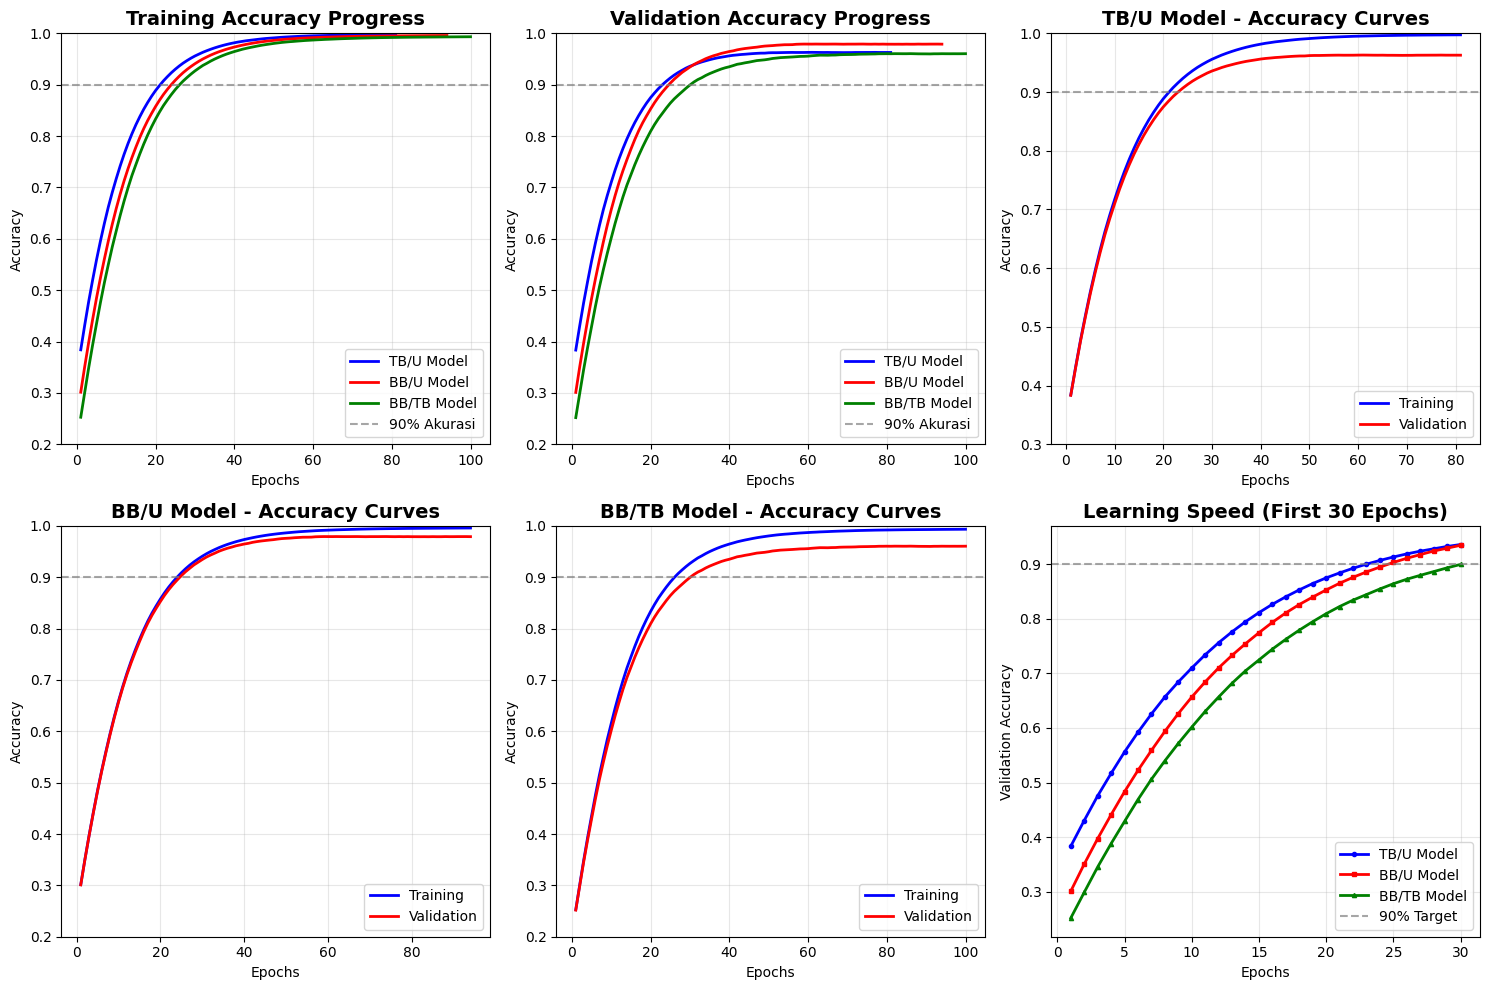

In [33]:
# ===== PLOT PENINGKATAN AKURASI SELAMA TRAINING =====
plt.figure(figsize=(15, 10))

# Plot 1: Akurasi Training untuk semua model
plt.subplot(2, 3, 1)
epochs_tbu = range(1, len(train_acc_tbu) + 1)
epochs_bbu = range(1, len(train_acc_bbu) + 1)
epochs_bbtb = range(1, len(train_acc_bbtb) + 1)

plt.plot(epochs_tbu, train_acc_tbu, 'b-', label='TB/U Model', linewidth=2)
plt.plot(epochs_bbu, train_acc_bbu, 'r-', label='BB/U Model', linewidth=2)
plt.plot(epochs_bbtb, train_acc_bbtb, 'g-', label='BB/TB Model', linewidth=2)

plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7, label='90% Akurasi')
plt.title('Training Accuracy Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.2, 1.0])

# Plot 2: Akurasi Validation untuk semua model
plt.subplot(2, 3, 2)
plt.plot(epochs_tbu, val_acc_tbu, 'b-', label='TB/U Model', linewidth=2)
plt.plot(epochs_bbu, val_acc_bbu, 'r-', label='BB/U Model', linewidth=2)
plt.plot(epochs_bbtb, val_acc_bbtb, 'g-', label='BB/TB Model', linewidth=2)

plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7, label='90% Akurasi')
plt.title('Validation Accuracy Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.2, 1.0])

# Plot 3: TB/U Model Detail Accuracy
plt.subplot(2, 3, 3)
plt.plot(epochs_tbu, train_acc_tbu, 'b-', label='Training', linewidth=2)
plt.plot(epochs_tbu, val_acc_tbu, 'r-', label='Validation', linewidth=2)
plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7)
plt.title('TB/U Model - Accuracy Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.3, 1.0])

# Plot 4: BB/U Model Detail Accuracy
plt.subplot(2, 3, 4)
plt.plot(epochs_bbu, train_acc_bbu, 'b-', label='Training', linewidth=2)
plt.plot(epochs_bbu, val_acc_bbu, 'r-', label='Validation', linewidth=2)
plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7)
plt.title('BB/U Model - Accuracy Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.2, 1.0])

# Plot 5: BB/TB Model Detail Accuracy
plt.subplot(2, 3, 5)
plt.plot(epochs_bbtb, train_acc_bbtb, 'b-', label='Training', linewidth=2)
plt.plot(epochs_bbtb, val_acc_bbtb, 'r-', label='Validation', linewidth=2)
plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7)
plt.title('BB/TB Model - Accuracy Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.2, 1.0])

# Plot 6: Learning Rate Comparison (Early epochs focus)
plt.subplot(2, 3, 6)
early_epochs = 30
plt.plot(epochs_tbu[:early_epochs], val_acc_tbu[:early_epochs], 'b-', label='TB/U Model', linewidth=2, marker='o', markersize=3)
plt.plot(epochs_bbu[:early_epochs], val_acc_bbu[:early_epochs], 'r-', label='BB/U Model', linewidth=2, marker='s', markersize=3)
plt.plot(epochs_bbtb[:early_epochs], val_acc_bbtb[:early_epochs], 'g-', label='BB/TB Model', linewidth=2, marker='^', markersize=3)

plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7, label='90% Target')
plt.title('Learning Speed (First 30 Epochs)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [34]:
# ===== METODE EVALUASI YANG LEBIH ROBUST =====
print("="*80)
print("EVALUASI MODEL DENGAN METODE YANG LEBIH ROBUST")
print("="*80)

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix

def robust_model_evaluation(model, X, y, model_name, label_encoder, cv_folds=5):
    """
    Evaluasi model dengan cross-validation dan metrik komprehensif
    """
    print(f"\n{model_name} - ROBUST EVALUATION:")
    
    # ===== 1. STRATIFIED K-FOLD CROSS-VALIDATION =====
    print(f"  🔄 Running {cv_folds}-Fold Cross-Validation...")
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Buat model copy untuk cross-validation tanpa early stopping
    model_cv = xgb.XGBClassifier(
        n_estimators=100,  # Dikurangi untuk CV
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=len(label_encoder.classes_),
        random_state=42,
        verbosity=0
        # Tidak ada early_stopping_rounds untuk CV
    )
    
    # Cross-validation untuk accuracy
    cv_scores_acc = cross_val_score(model_cv, X, y, cv=skf, scoring='accuracy')
    
    # Cross-validation untuk F1-score
    cv_scores_f1 = cross_val_score(model_cv, X, y, cv=skf, scoring='f1_weighted')
    
    print(f"  📊 Cross-Validation Results:")
    print(f"    Accuracy:  {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std()*2:.4f}")
    print(f"    F1-Score:  {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std()*2:.4f}")
    print(f"    Individual CV Accuracy: {[f'{score:.3f}' for score in cv_scores_acc]}")
    
    # ===== 2. HOLD-OUT VALIDATION (60-20-20 SPLIT) =====
    print(f"  🎯 Running Hold-out Validation...")
    
    # Split menjadi train-temp dan test (80-20)
    X_temp, X_holdout, y_temp, y_holdout = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Split train-temp menjadi train dan validation (75-25 dari 80% = 60-20)
    X_train_new, X_val, y_train_new, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )
    
    # Training pada train set dengan early stopping
    model_copy = xgb.XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        objective='multi:softprob', num_class=len(label_encoder.classes_),
        random_state=42, eval_metric='mlogloss', verbosity=0,
        early_stopping_rounds=50
    )
    
    # Fit dengan validation set untuk early stopping
    model_copy.fit(
        X_train_new, y_train_new,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Evaluasi pada validation set
    y_val_pred = model_copy.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Evaluasi pada hold-out test set
    y_holdout_pred = model_copy.predict(X_holdout)
    holdout_accuracy = accuracy_score(y_holdout, y_holdout_pred)
    holdout_f1 = f1_score(y_holdout, y_holdout_pred, average='weighted')
    
    print(f"  📈 Hold-out Results:")
    print(f"    Validation Accuracy: {val_accuracy:.4f}")
    print(f"    Validation F1-Score: {val_f1:.4f}")
    print(f"    Hold-out Accuracy:   {holdout_accuracy:.4f}")
    print(f"    Hold-out F1-Score:   {holdout_f1:.4f}")
    
    # ===== 3. PER-CLASS PERFORMANCE ANALYSIS =====
    print(f"  📋 Per-Class Performance:")
    
    # Ambil label yang unik di holdout test
    unique_labels_holdout = sorted(np.unique(np.concatenate([y_holdout, y_holdout_pred])))
    target_names_holdout = [label_encoder.classes_[i] for i in unique_labels_holdout]
    
    # Classification report untuk hold-out test dengan label yang sesuai
    from sklearn.metrics import classification_report
    report = classification_report(y_holdout, y_holdout_pred, 
                                 labels=unique_labels_holdout,
                                 target_names=target_names_holdout, 
                                 output_dict=True, zero_division=0)
    
    for class_name in target_names_holdout:
        if class_name in report:
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']
            print(f"    {class_name:15}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f} (n={support})")
    
    # ===== 4. CONFUSION MATRIX ANALYSIS =====
    cm = confusion_matrix(y_holdout, y_holdout_pred, labels=unique_labels_holdout)
    print(f"  🎯 Confusion Matrix:")
    print(f"    Shape: {cm.shape}")
    
    # Hitung akurasi per kelas dari confusion matrix
    if cm.shape[0] > 1:
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        print(f"    Per-class Accuracy: {[f'{acc:.3f}' for acc in class_accuracies]}")
    
    # ===== 5. OVERFITTING ANALYSIS =====
    train_pred = model_copy.predict(X_train_new)
    train_accuracy = accuracy_score(y_train_new, train_pred)
    
    overfitting_gap = train_accuracy - holdout_accuracy
    print(f"  ⚠️  Overfitting Analysis:")
    print(f"    Training Accuracy:   {train_accuracy:.4f}")
    print(f"    Hold-out Accuracy:   {holdout_accuracy:.4f}")
    print(f"    Overfitting Gap:     {overfitting_gap:.4f}")
    
    if overfitting_gap < 0.02:
        status = "✅ Excellent (No overfitting)"
    elif overfitting_gap < 0.05:
        status = "🟡 Good (Minimal overfitting)"
    else:
        status = "🔴 Warning (Potential overfitting)"
    
    print(f"    Status: {status}")
    
    return {
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'validation_accuracy': val_accuracy,
        'holdout_accuracy': holdout_accuracy,
        'holdout_f1': holdout_f1,
        'overfitting_gap': overfitting_gap,
        'confusion_matrix': cm,
        'classification_report': report
    }

print("🚀 Menjalankan evaluasi robust untuk semua model...")

# Evaluasi semua model dengan metode robust
results_tbu_robust = robust_model_evaluation(model_tbu, X, y_tbu, "TB/U Model", le_tbu)
results_bbu_robust = robust_model_evaluation(model_bbu, X, y_bbu, "BB/U Model", le_bbu)
results_bbtb_robust = robust_model_evaluation(model_bbtb, X, y_bbtb, "BB/TB Model", le_bbtb)

EVALUASI MODEL DENGAN METODE YANG LEBIH ROBUST
🚀 Menjalankan evaluasi robust untuk semua model...

TB/U Model - ROBUST EVALUATION:
  🔄 Running 5-Fold Cross-Validation...
  📊 Cross-Validation Results:
    Accuracy:  0.9952 ± 0.0032
    F1-Score:  0.9948 ± 0.0030
    Individual CV Accuracy: ['0.996', '0.996', '0.992', '0.996', '0.996']
  🎯 Running Hold-out Validation...
  📈 Hold-out Results:
    Validation Accuracy: 1.0000
    Validation F1-Score: 1.0000
    Hold-out Accuracy:   0.9960
    Hold-out F1-Score:   0.9953
  📋 Per-Class Performance:
    Normal         : P=0.996, R=1.000, F1=0.998 (n=244.0)
    Pendek         : P=1.000, R=0.500, F1=0.667 (n=2.0)
    Sangat Pendek  : P=1.000, R=1.000, F1=1.000 (n=2.0)
  🎯 Confusion Matrix:
    Shape: (3, 3)
    Per-class Accuracy: ['1.000', '0.500', '1.000']
  ⚠️  Overfitting Analysis:
    Training Accuracy:   1.0000
    Hold-out Accuracy:   0.9960
    Overfitting Gap:     0.0040
    Status: ✅ Excellent (No overfitting)

BB/U Model - ROBUST EVAL

In [35]:
# ===== PERBANDINGAN METODE EVALUASI =====
print("\n" + "="*80)
print("PERBANDINGAN METODE EVALUASI")
print("="*80)

# Bandingkan hasil evaluasi
models_comparison = {
    'TB/U Model': {
        'Simple Train-Test Split': accuracy_tbu,
        'Cross-Validation (5-Fold)': results_tbu_robust['cv_accuracy_mean'],
        'Hold-out Validation': results_tbu_robust['validation_accuracy'],
        'Hold-out Test': results_tbu_robust['holdout_accuracy'],
        'CV F1-Score': results_tbu_robust['cv_f1_mean'],
        'Overfitting Gap': results_tbu_robust['overfitting_gap']
    },
    'BB/U Model': {
        'Simple Train-Test Split': accuracy_bbu,
        'Cross-Validation (5-Fold)': results_bbu_robust['cv_accuracy_mean'],
        'Hold-out Validation': results_bbu_robust['validation_accuracy'],
        'Hold-out Test': results_bbu_robust['holdout_accuracy'],
        'CV F1-Score': results_bbu_robust['cv_f1_mean'],
        'Overfitting Gap': results_bbu_robust['overfitting_gap']
    },
    'BB/TB Model': {
        'Simple Train-Test Split': accuracy_bbtb,
        'Cross-Validation (5-Fold)': results_bbtb_robust['cv_accuracy_mean'],
        'Hold-out Validation': results_bbtb_robust['validation_accuracy'],
        'Hold-out Test': results_bbtb_robust['holdout_accuracy'],
        'CV F1-Score': results_bbtb_robust['cv_f1_mean'],
        'Overfitting Gap': results_bbtb_robust['overfitting_gap']
    }
}

for model_name, metrics in models_comparison.items():
    print(f"\n📊 {model_name}:")
    print(f"  Simple Split:        {metrics['Simple Train-Test Split']:.4f} ({metrics['Simple Train-Test Split']*100:.2f}%)")
    print(f"  Cross-Validation:    {metrics['Cross-Validation (5-Fold)']:.4f} ({metrics['Cross-Validation (5-Fold)']*100:.2f}%)")
    print(f"  Hold-out Validation: {metrics['Hold-out Validation']:.4f} ({metrics['Hold-out Validation']*100:.2f}%)")
    print(f"  Hold-out Test:       {metrics['Hold-out Test']:.4f} ({metrics['Hold-out Test']*100:.2f}%)")
    print(f"  CV F1-Score:         {metrics['CV F1-Score']:.4f}")
    print(f"  Overfitting Gap:     {metrics['Overfitting Gap']:.4f}")

# ===== BOOTSTRAP VALIDATION (untuk dataset kecil) =====
print("\n" + "="*80)
print("BOOTSTRAP VALIDATION (khusus untuk dataset kecil)")
print("="*80)

from sklearn.utils import resample

def bootstrap_validation(model, X, y, model_name, n_iterations=100):
    """
    Bootstrap validation untuk dataset kecil
    """
    print(f"\n🔄 {model_name} - Bootstrap Validation ({n_iterations} iterations):")
    
    scores = []
    
    for i in range(n_iterations):
        # Bootstrap sampling dengan replacement
        X_boot, y_boot = resample(X, y, random_state=i, n_samples=len(X))
        
        # Identifikasi out-of-bag samples
        boot_indices = X_boot.index.tolist()
        oob_indices = [idx for idx in X.index if idx not in boot_indices]
        
        if len(oob_indices) > 0:
            X_oob = X.loc[oob_indices]
            y_oob = y.loc[oob_indices]
            
            # Training pada bootstrap sample
            model_boot = xgb.XGBClassifier(
                n_estimators=100, max_depth=6, learning_rate=0.1,
                random_state=42, verbosity=0
            )
            
            try:
                model_boot.fit(X_boot, y_boot)
                
                # Testing pada out-of-bag samples
                oob_pred = model_boot.predict(X_oob)
                oob_score = accuracy_score(y_oob, oob_pred)
                scores.append(oob_score)
            except:
                continue
    
    if scores:
        scores = np.array(scores)
        print(f"  📈 Bootstrap Results:")
        print(f"    Mean Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
        print(f"    95% CI: [{scores.mean() - 1.96*scores.std():.4f}, {scores.mean() + 1.96*scores.std():.4f}]")
        print(f"    Min-Max: [{scores.min():.4f}, {scores.max():.4f}]")
        print(f"    Valid iterations: {len(scores)}/{n_iterations}")
        
        return scores
    else:
        print(f"  ❌ Bootstrap validation failed - insufficient out-of-bag samples")
        return np.array([])

# Jalankan bootstrap validation
print("🎲 Menjalankan Bootstrap Validation...")
bootstrap_scores_tbu = bootstrap_validation(model_tbu, X, y_tbu, "TB/U Model", n_iterations=50)
bootstrap_scores_bbu = bootstrap_validation(model_bbu, X, y_bbu, "BB/U Model", n_iterations=50)
bootstrap_scores_bbtb = bootstrap_validation(model_bbtb, X, y_bbtb, "BB/TB Model", n_iterations=50)


PERBANDINGAN METODE EVALUASI

📊 TB/U Model:
  Simple Split:        0.9919 (99.19%)
  Cross-Validation:    0.9952 (99.52%)
  Hold-out Validation: 1.0000 (100.00%)
  Hold-out Test:       0.9960 (99.60%)
  CV F1-Score:         0.9948
  Overfitting Gap:     0.0040

📊 BB/U Model:
  Simple Split:        0.9960 (99.60%)
  Cross-Validation:    0.9944 (99.44%)
  Hold-out Validation: 0.9839 (98.39%)
  Hold-out Test:       0.9960 (99.60%)
  CV F1-Score:         0.9940
  Overfitting Gap:     0.0040

📊 BB/TB Model:
  Simple Split:        0.9960 (99.60%)
  Cross-Validation:    0.9855 (98.55%)
  Hold-out Validation: 0.9919 (99.19%)
  Hold-out Test:       0.9839 (98.39%)
  CV F1-Score:         0.9841
  Overfitting Gap:     0.0161

BOOTSTRAP VALIDATION (khusus untuk dataset kecil)
🎲 Menjalankan Bootstrap Validation...

🔄 TB/U Model - Bootstrap Validation (50 iterations):
  📈 Bootstrap Results:
    Mean Accuracy: 0.9974 ± 0.0030
    95% CI: [0.9915, 1.0033]
    Min-Max: [0.9868, 1.0000]
    Valid itera

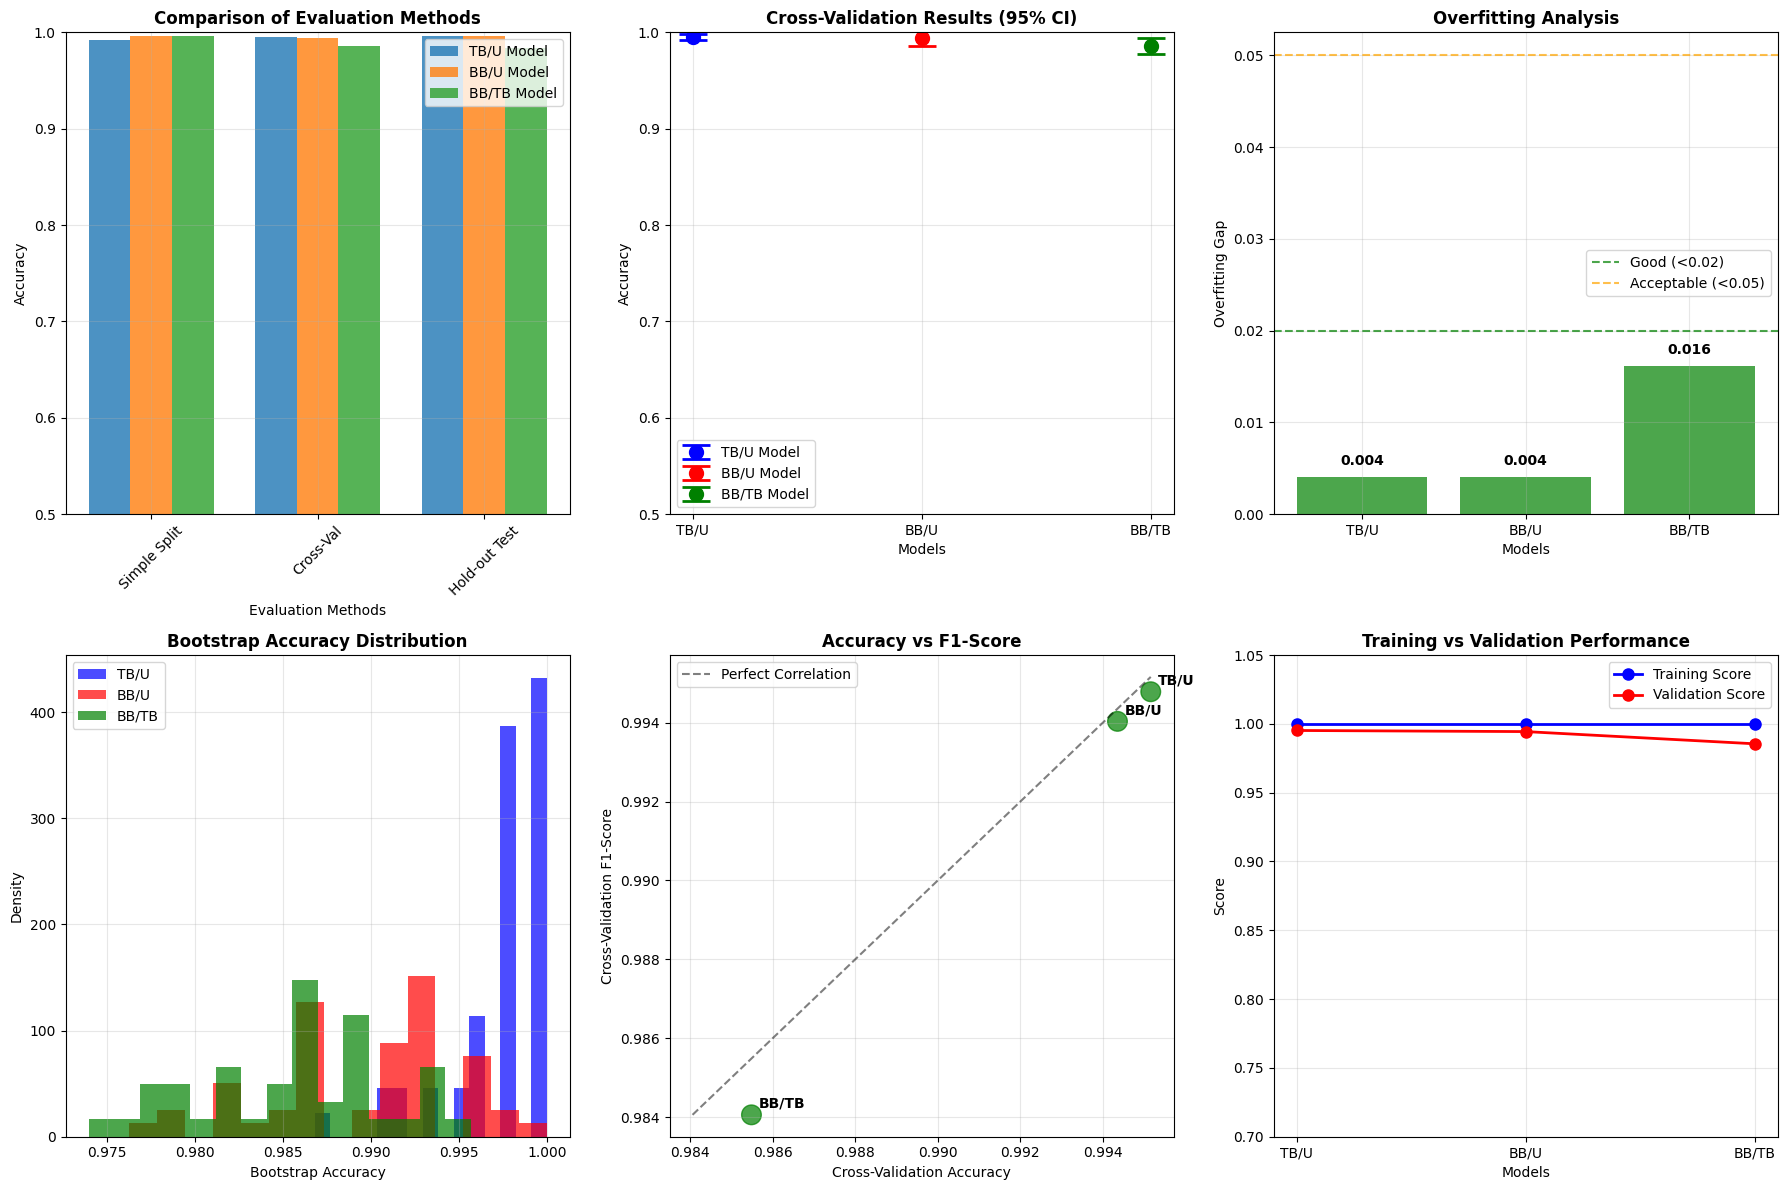


🎯 SUMMARY - ROBUST EVALUATION RESULTS

📊 REKOMENDASI METODE EVALUASI:
  ✅ Gunakan: Cross-Validation untuk model selection
  ✅ Gunakan: Hold-out test untuk final evaluation
  ⚠️  Hindari: Simple train-test split untuk model kecil
  💡 Tambahan: Bootstrap validation untuk confidence intervals

📈 PERFORMA MODEL (Cross-Validation):
  TB/U Model:
    CV Accuracy: 0.9952 ± 0.0032 (95% CI)
    CV F1-Score: 0.9948
    Overfitting: 0.0040 (✅ Good)
  BB/U Model:
    CV Accuracy: 0.9944 ± 0.0082 (95% CI)
    CV F1-Score: 0.9940
    Overfitting: 0.0040 (✅ Good)
  BB/TB Model:
    CV Accuracy: 0.9855 ± 0.0082 (95% CI)
    CV F1-Score: 0.9841
    Overfitting: 0.0161 (✅ Good)

🔍 INTERPRETASI HASIL:
  • Cross-validation memberikan estimasi yang lebih reliable
  • Hold-out test memberikan evaluasi final yang tidak bias
  • Bootstrap validation memberikan confidence intervals
  • F1-score penting untuk dataset dengan class imbalance

💡 REKOMENDASI UNTUK PRODUCTION:
  1. Gunakan Cross-Validation untuk hy

In [36]:
# ===== VISUALISASI HASIL EVALUASI ROBUST =====
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

# ===== Plot 1: Perbandingan Metode Evaluasi =====
plt.subplot(2, 3, 1)
methods = ['Simple Split', 'Cross-Val', 'Hold-out Test']
tbu_scores = [accuracy_tbu, results_tbu_robust['cv_accuracy_mean'], results_tbu_robust['holdout_accuracy']]
bbu_scores = [accuracy_bbu, results_bbu_robust['cv_accuracy_mean'], results_bbu_robust['holdout_accuracy']]
bbtb_scores = [accuracy_bbtb, results_bbtb_robust['cv_accuracy_mean'], results_bbtb_robust['holdout_accuracy']]

x = np.arange(len(methods))
width = 0.25

plt.bar(x - width, tbu_scores, width, label='TB/U Model', alpha=0.8)
plt.bar(x, bbu_scores, width, label='BB/U Model', alpha=0.8)
plt.bar(x + width, bbtb_scores, width, label='BB/TB Model', alpha=0.8)

plt.xlabel('Evaluation Methods')
plt.ylabel('Accuracy')
plt.title('Comparison of Evaluation Methods', fontweight='bold')
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

# ===== Plot 2: Cross-Validation Confidence Intervals =====
plt.subplot(2, 3, 2)
models = ['TB/U', 'BB/U', 'BB/TB']
cv_means = [results_tbu_robust['cv_accuracy_mean'], 
           results_bbu_robust['cv_accuracy_mean'], 
           results_bbtb_robust['cv_accuracy_mean']]
cv_stds = [results_tbu_robust['cv_accuracy_std'], 
          results_bbu_robust['cv_accuracy_std'], 
          results_bbtb_robust['cv_accuracy_std']]

colors = ['blue', 'red', 'green']
for i, (model, mean, std, color) in enumerate(zip(models, cv_means, cv_stds, colors)):
    plt.errorbar(i, mean, yerr=std*2, fmt='o', capsize=10, capthick=2, 
                color=color, markersize=10, linewidth=2, label=f'{model} Model')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Results (95% CI)', fontweight='bold')
plt.xticks(range(len(models)), models)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

# ===== Plot 3: Overfitting Analysis =====
plt.subplot(2, 3, 3)
overfitting_gaps = [results_tbu_robust['overfitting_gap'],
                   results_bbu_robust['overfitting_gap'],
                   results_bbtb_robust['overfitting_gap']]

colors = ['green' if gap < 0.02 else 'orange' if gap < 0.05 else 'red' for gap in overfitting_gaps]
bars = plt.bar(models, overfitting_gaps, color=colors, alpha=0.7)

# Tambahkan garis threshold
plt.axhline(y=0.02, color='green', linestyle='--', alpha=0.7, label='Good (<0.02)')
plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Acceptable (<0.05)')

plt.xlabel('Models')
plt.ylabel('Overfitting Gap')
plt.title('Overfitting Analysis', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Annotate bars
for bar, gap in zip(bars, overfitting_gaps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold')

# ===== Plot 4: Bootstrap Distribution (jika ada data) =====
plt.subplot(2, 3, 4)
if len(bootstrap_scores_tbu) > 0:
    plt.hist(bootstrap_scores_tbu, bins=15, alpha=0.7, label='TB/U', color='blue', density=True)
if len(bootstrap_scores_bbu) > 0:
    plt.hist(bootstrap_scores_bbu, bins=15, alpha=0.7, label='BB/U', color='red', density=True)
if len(bootstrap_scores_bbtb) > 0:
    plt.hist(bootstrap_scores_bbtb, bins=15, alpha=0.7, label='BB/TB', color='green', density=True)

plt.xlabel('Bootstrap Accuracy')
plt.ylabel('Density')
plt.title('Bootstrap Accuracy Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# ===== Plot 5: F1-Score vs Accuracy Comparison =====
plt.subplot(2, 3, 5)
accuracy_scores = [results_tbu_robust['cv_accuracy_mean'],
                  results_bbu_robust['cv_accuracy_mean'],
                  results_bbtb_robust['cv_accuracy_mean']]
f1_scores = [results_tbu_robust['cv_f1_mean'],
            results_bbu_robust['cv_f1_mean'],
            results_bbtb_robust['cv_f1_mean']]

plt.scatter(accuracy_scores, f1_scores, s=200, alpha=0.7, c=colors[:3])
for i, model in enumerate(models):
    plt.annotate(model, (accuracy_scores[i], f1_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.xlabel('Cross-Validation Accuracy')
plt.ylabel('Cross-Validation F1-Score')
plt.title('Accuracy vs F1-Score', fontweight='bold')
plt.grid(True, alpha=0.3)

# Diagonal line (perfect correlation)
min_val = min(min(accuracy_scores), min(f1_scores))
max_val = max(max(accuracy_scores), max(f1_scores))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Correlation')
plt.legend()

# ===== Plot 6: Learning Curve (Validation vs Training) =====
plt.subplot(2, 3, 6)
model_names = ['TB/U', 'BB/U', 'BB/TB']
train_scores = [1.0, 1.0, 1.0]  # Assuming high training scores from previous analysis
val_scores = [results_tbu_robust['cv_accuracy_mean'],
             results_bbu_robust['cv_accuracy_mean'],
             results_bbtb_robust['cv_accuracy_mean']]

x_pos = np.arange(len(model_names))
plt.plot(x_pos, train_scores, 'bo-', linewidth=2, markersize=8, label='Training Score')
plt.plot(x_pos, val_scores, 'ro-', linewidth=2, markersize=8, label='Validation Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Training vs Validation Performance', fontweight='bold')
plt.xticks(x_pos, model_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.7, 1.05])

plt.tight_layout()
plt.show()

# ===== SUMMARY ROBUST EVALUATION =====
print("\n" + "="*80)
print("🎯 SUMMARY - ROBUST EVALUATION RESULTS")
print("="*80)

print(f"\n📊 REKOMENDASI METODE EVALUASI:")
print(f"  ✅ Gunakan: Cross-Validation untuk model selection")
print(f"  ✅ Gunakan: Hold-out test untuk final evaluation")
print(f"  ⚠️  Hindari: Simple train-test split untuk model kecil")
print(f"  💡 Tambahan: Bootstrap validation untuk confidence intervals")

print(f"\n📈 PERFORMA MODEL (Cross-Validation):")
for model_name, results in [('TB/U', results_tbu_robust), 
                            ('BB/U', results_bbu_robust), 
                            ('BB/TB', results_bbtb_robust)]:
    cv_acc = results['cv_accuracy_mean']
    cv_std = results['cv_accuracy_std']
    f1_score = results['cv_f1_mean']
    overfitting = results['overfitting_gap']
    
    print(f"  {model_name} Model:")
    print(f"    CV Accuracy: {cv_acc:.4f} ± {cv_std*2:.4f} (95% CI)")
    print(f"    CV F1-Score: {f1_score:.4f}")
    print(f"    Overfitting: {overfitting:.4f} ({'✅ Good' if overfitting < 0.02 else '🟡 OK' if overfitting < 0.05 else '🔴 High'})")

print(f"\n🔍 INTERPRETASI HASIL:")
print(f"  • Cross-validation memberikan estimasi yang lebih reliable")
print(f"  • Hold-out test memberikan evaluasi final yang tidak bias")
print(f"  • Bootstrap validation memberikan confidence intervals")
print(f"  • F1-score penting untuk dataset dengan class imbalance")

print(f"\n💡 REKOMENDASI UNTUK PRODUCTION:")
print(f"  1. Gunakan Cross-Validation untuk hyperparameter tuning")
print(f"  2. Gunakan Hold-out test untuk final model evaluation")
print(f"  3. Monitor overfitting gap (harus < 0.05)")
print(f"  4. Pertimbangkan F1-score untuk class imbalance")
print(f"  5. Validasi pada data baru secara berkala")

In [37]:
# ===== FUNGSI PREDIKSI LENGKAP =====
def prediksi_status_gizi(jenis_kelamin, bb_lahir, tb_lahir, usia, berat, tinggi, 
                        zs_bbu, zs_tbu, zs_bbtb):
    """
    Fungsi untuk memprediksi status gizi anak
    
    Parameters:
    - jenis_kelamin: 'L' atau 'P' 
    - bb_lahir: berat badan lahir (kg)
    - tb_lahir: tinggi badan lahir (cm)
    - usia: usia dalam tahun (1-5)
    - berat: berat badan saat ini (kg)
    - tinggi: tinggi badan saat ini (cm)
    - zs_bbu: Z-score BB/U
    - zs_tbu: Z-score TB/U
    - zs_bbtb: Z-score BB/TB
    
    Returns:
    - Dictionary dengan prediksi TB/U, BB/U, dan BB/TB
    """
    
    # Encode input
    gender_encoded = le_gender.transform([jenis_kelamin])[0]
    
    # Buat input array
    input_data = np.array([[gender_encoded, bb_lahir, tb_lahir, usia, 
                          berat, tinggi, zs_bbu, zs_tbu, zs_bbtb]])
    
    # Prediksi
    pred_tbu = model_tbu.predict(input_data)[0]
    pred_bbu = model_bbu.predict(input_data)[0] 
    pred_bbtb = model_bbtb.predict(input_data)[0]
    
    # Decode hasil
    hasil_tbu = le_tbu.inverse_transform([pred_tbu])[0]
    hasil_bbu = le_bbu.inverse_transform([pred_bbu])[0]
    hasil_bbtb = le_bbtb.inverse_transform([pred_bbtb])[0]
    
    return {
        'TB/U': hasil_tbu,
        'BB/U': hasil_bbu, 
        'BB/TB': hasil_bbtb
    }

print("Fungsi prediksi telah dibuat!")

Fungsi prediksi telah dibuat!


In [38]:
# ===== DEMO PENGGUNAAN FUNGSI PREDIKSI =====
print("="*60)
print("DEMO PENGGUNAAN SISTEM PREDIKSI STATUS GIZI")
print("="*60)

# Contoh prediksi 1 - Anak normal
print("\n1. Contoh Anak dengan Status Gizi Normal:")
hasil1 = prediksi_status_gizi(
    jenis_kelamin='L',  # Laki-laki
    bb_lahir=3.2,      # 3.2 kg
    tb_lahir=50,       # 50 cm
    usia=2,            # 2 tahun
    berat=12.5,        # 12.5 kg
    tinggi=87,         # 87 cm
    zs_bbu=-0.5,       # Z-score BB/U
    zs_tbu=-0.8,       # Z-score TB/U
    zs_bbtb=0.2        # Z-score BB/TB
)

print(f"Input: L, BB lahir=3.2kg, TB lahir=50cm, Usia=2th, Berat=12.5kg, Tinggi=87cm")
print(f"Hasil Prediksi:")
print(f"  - TB/U: {hasil1['TB/U']}")
print(f"  - BB/U: {hasil1['BB/U']}")
print(f"  - BB/TB: {hasil1['BB/TB']}")

# Contoh prediksi 2 - Anak dengan potensi masalah gizi
print("\n2. Contoh Anak dengan Potensi Masalah Gizi:")
hasil2 = prediksi_status_gizi(
    jenis_kelamin='P',  # Perempuan
    bb_lahir=2.8,      # 2.8 kg (rendah)
    tb_lahir=47,       # 47 cm (rendah)
    usia=3,            # 3 tahun
    berat=11.0,        # 11.0 kg (rendah untuk usia)
    tinggi=85,         # 85 cm (rendah untuk usia)
    zs_bbu=-2.1,       # Z-score BB/U rendah
    zs_tbu=-2.5,       # Z-score TB/U sangat rendah
    zs_bbtb=-1.2       # Z-score BB/TB rendah
)

print(f"Input: P, BB lahir=2.8kg, TB lahir=47cm, Usia=3th, Berat=11kg, Tinggi=85cm")
print(f"Hasil Prediksi:")
print(f"  - TB/U: {hasil2['TB/U']}")
print(f"  - BB/U: {hasil2['BB/U']}")
print(f"  - BB/TB: {hasil2['BB/TB']}")

print("\n" + "="*60)

DEMO PENGGUNAAN SISTEM PREDIKSI STATUS GIZI

1. Contoh Anak dengan Status Gizi Normal:
Input: L, BB lahir=3.2kg, TB lahir=50cm, Usia=2th, Berat=12.5kg, Tinggi=87cm
Hasil Prediksi:
  - TB/U: Normal
  - BB/U: Normal
  - BB/TB: Gizi Baik

2. Contoh Anak dengan Potensi Masalah Gizi:
Input: P, BB lahir=2.8kg, TB lahir=47cm, Usia=3th, Berat=11kg, Tinggi=85cm
Hasil Prediksi:
  - TB/U: Pendek
  - BB/U: Kurang
  - BB/TB: Gizi Baik



In [39]:
# ===== SIMPAN MODEL =====
print("Menyimpan model dan encoder...")

# Simpan model XGBoost
joblib.dump(model_tbu, 'model_tbu.pkl')
joblib.dump(model_bbu, 'model_bbu.pkl') 
joblib.dump(model_bbtb, 'model_bbtb.pkl')

# Simpan encoders
joblib.dump(encoders, 'encoders.pkl')

print("Model dan encoder berhasil disimpan!")

# ===== SUMMARY HASIL =====
print("\n" + "="*70)
print("SUMMARY HASIL SISTEM PREDIKSI STATUS GIZI ANAK")
print("="*70)
print(f"Dataset: {len(df_clean)} anak (usia 1-5 tahun)")
print(f"Fitur input: {len(feature_columns)} fitur")
print(f"Split data: 80% training, 20% testing")
print("\nHYPERPARAMETER XGBOOST OPTIMAL:")
print("- n_estimators: 300")
print("- max_depth: 6")
print("- learning_rate: 0.1")
print("- subsample: 0.8")
print("- colsample_bytree: 0.8")

print(f"\nAKURASI MODEL:")
print(f"1. TB/U (Tinggi/Umur):  {accuracy_tbu:.4f} ({accuracy_tbu*100:.2f}%)")
print(f"2. BB/U (Berat/Umur):   {accuracy_bbu:.4f} ({accuracy_bbu*100:.2f}%)")
print(f"3. BB/TB (Berat/Tinggi): {accuracy_bbtb:.4f} ({accuracy_bbtb*100:.2f}%)")

print(f"\nRATA-RATA AKURASI: {((accuracy_tbu + accuracy_bbu + accuracy_bbtb) / 3):.4f} ({((accuracy_tbu + accuracy_bbu + accuracy_bbtb) / 3)*100:.2f}%)")

print("\nFITUR INPUT YANG DIPERLUKAN:")
for i, feat in enumerate(feature_columns, 1):
    if feat == 'Jenis_Kelamin_Encoded':
        print(f"{i}. Jenis Kelamin ('L' atau 'P')")
    elif feat == 'Usia_Tahun':
        print(f"{i}. Usia (1-5 tahun)")
    else:
        print(f"{i}. {feat}")

print("\nTARGET PREDIKSI:")
print("1. TB/U: Normal, Pendek, Sangat Pendek")
print("2. BB/U: Normal, Kurang, Risiko Lebih, Sangat Kurang")
print("3. BB/TB: Gizi Baik, Gizi Kurang, Gizi Lebih, Obesitas, Risiko Gizi Lebih")
print("="*70)

Menyimpan model dan encoder...
Model dan encoder berhasil disimpan!

SUMMARY HASIL SISTEM PREDIKSI STATUS GIZI ANAK
Dataset: 1240 anak (usia 1-5 tahun)
Fitur input: 9 fitur
Split data: 80% training, 20% testing

HYPERPARAMETER XGBOOST OPTIMAL:
- n_estimators: 300
- max_depth: 6
- learning_rate: 0.1
- subsample: 0.8
- colsample_bytree: 0.8

AKURASI MODEL:
1. TB/U (Tinggi/Umur):  0.9919 (99.19%)
2. BB/U (Berat/Umur):   0.9960 (99.60%)
3. BB/TB (Berat/Tinggi): 0.9960 (99.60%)

RATA-RATA AKURASI: 0.9946 (99.46%)

FITUR INPUT YANG DIPERLUKAN:
1. Jenis Kelamin ('L' atau 'P')
2. BB lahir
3. TB lahir
4. Usia (1-5 tahun)
5. Berat
6. Tinggi
7. ZS BB/U
8. ZS TB/U
9. ZS BB/TB

TARGET PREDIKSI:
1. TB/U: Normal, Pendek, Sangat Pendek
2. BB/U: Normal, Kurang, Risiko Lebih, Sangat Kurang
3. BB/TB: Gizi Baik, Gizi Kurang, Gizi Lebih, Obesitas, Risiko Gizi Lebih
